In [1]:
import json
from importlib import reload

import torch
import numpy as np
import pandas as pd 
from tqdm.auto import tqdm
from sklearn.metrics import balanced_accuracy_score

In [2]:
# model class 

import torch 
from torch import nn 
from tqdm.auto import tqdm 

class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, nclasses, device) -> None:
        super().__init__()

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim).to(device)
        self.lstm_model = nn.LSTM(embedding_dim, hidden_size//2, bidirectional=True).to(device)
        self.ffwd_lay = nn.Linear(hidden_size, nclasses).to(device)
        self.softmax = nn.Softmax(dim=1).to(device)

        self.optim = torch.optim.Adam(self.parameters(), lr=1e-2)
        self.criterion = nn.CrossEntropyLoss()
        
        self.loss_history = []


    def forward(self, batch):
        out = self.embedding(batch) # L x vocab_size -> L x embedding_dim
        out = self.lstm_model(out)[0] # L x hidden_size
        out = self.ffwd_lay(out) # L x nclasses
        return self.softmax(out)


    def fit(self, train_X, train_Y, nepochs, lr, device):
        self.train()
        self.to(device)

        for g in self.optim.param_groups:
            g['lr'] = lr    
        
        for ep in tqdm(range(nepochs)):
            eploss = 0

            for batch_X, batch_Y in tqdm(zip(train_X, train_Y)):
                predict = self.forward(batch_X.to(device))
                
                self.optim.zero_grad()
                loss = self.criterion(predict, batch_Y.to(device))
                loss.backward()
                self.optim.step()

                eploss += loss.item()
                self.loss_history.append(loss.item())
            
            printbool = ep % (nepochs//10) == 0 if nepochs > 10 else True
            if printbool:
                print(f'Train loss: {eploss/len(train_X):.3f}')

In [3]:
def data_label_split(data, label, train_size=0.8):
    randidx = np.arange(len(data))
    data_train, data_test = train_test_split(data, randidx, train_size)
    label_train, label_test = train_test_split(label, randidx, train_size)

    return data_train, data_test, label_train, label_test

def train_test_split(data, randidx, train_size):
    N = len(data)
    return [data[i] for i in randidx[:int(train_size*N)]], [data[i] for i in randidx[int(train_size*N):]]

def shuffle_data_label_lists(data, label):
    randidx = np.arange(len(data))
    np.random.shuffle(randidx)
    return [data[i] for i in randidx], [label[i] for i in randidx]

def batch_split(X, Y, seq_len, batch_size=1000):
    x_batched = []
    y_batched = []
    seq_len_batched = []

    n = len(X)
    pointer = 0
    while pointer + batch_size < n:
        x_batched.append(X[pointer:pointer+batch_size])
        y_batched.append(Y[pointer:pointer+batch_size])
        seq_len_batched.append(seq_len[pointer:pointer+batch_size])
        pointer += batch_size 
    
    x_batched.append(X[pointer:])
    y_batched.append(Y[pointer:])
    seq_len_batched.append(seq_len[pointer:])

    return x_batched, y_batched, seq_len_batched

In [25]:
# encoding tokens and labels
with open('data/mixtral-8x7b-v1.json', 'r', encoding='utf-8') as f:
    data_1 = json.load(f)
with open('data/train.json', 'r', encoding='utf-8') as f:
    data_2 = json.load(f)

data = data_1 + data_2

unique_tokens, unique_labels = set(), set()
for doc_i, doc in enumerate(tqdm(data)):
    unique_tokens |= set(np.unique(doc['tokens']))
    unique_labels |= set(np.unique(doc['labels']))

token2num = dict(zip(unique_tokens, range(1, len(unique_tokens)+1)))
label2num = {
    'O': 0,
    'B-URL_PERSONAL': 1, 
    'I-URL_PERSONAL': 1, 
    'B-ID_NUM': 2, 
    'I-ID_NUM': 2, 
    'B-EMAIL': 3, 
    'I-EMAIL': 3,
    'B-NAME_STUDENT': 0, 
    'I-NAME_STUDENT': 0, 
    'B-PHONE_NUM': 4, 
    'I-PHONE_NUM': 4, 
    'B-USERNAME': 5,
    'I-USERNAME': 5, 
    'B-STREET_ADDRESS': 6, 
    'I-STREET_ADDRESS': 6, 
}
num2token = {}
for it in token2num:
    num2token[token2num[it]] = it

  0%|          | 0/9162 [00:00<?, ?it/s]

In [37]:
# load data and split by sentences
sentences = []
cur_sentence = []
sentences_labels = []
cur_sentences_labels = []

for doc_i, doc in enumerate(tqdm(data)):
    for token, label in zip(data[doc_i]['tokens'], data[doc_i]['labels']):
        cur_sentence.append(token2num[token])
        cur_sentences_labels.append(label2num[label])

        if (token == '.') | (token.endswith('\n')) | (token == '?') | (token == '!'):  
            if len(cur_sentence) > 2: 
                sentences.append(torch.LongTensor(cur_sentence))
                sentences_labels.append(torch.LongTensor(cur_sentences_labels))

            cur_sentences_labels = []
            cur_sentence = []
    
    if len(cur_sentence) > 2:
        sentences.append(torch.LongTensor(cur_sentence))
        sentences_labels.append(torch.LongTensor(cur_sentences_labels))

    cur_sentences_labels = []
    cur_sentence = []
    
    
# create train and test df
class_split_sentences = {
    'O': [[],[]],
    # 'B-NAME_STUDENT': [[],[]],    
    'B-STREET_ADDRESS': [[],[]],
    'B-URL_PERSONAL': [[],[]],
    'B-ID_NUM': [[],[]],
    'B-EMAIL': [[],[]],
    'B-PHONE_NUM': [[],[]],
    'B-USERNAME': [[],[]],
}

classes_link = {}
for it in class_split_sentences:
    classes_link[label2num[it]] = it
unique_classes = classes_link.keys()

for i, it in enumerate(sentences):
    for cl in unique_classes:
        if cl in sentences_labels[i]:
            class_split_sentences[classes_link[cl]][0].append(sentences[i])
            class_split_sentences[classes_link[cl]][1].append(sentences_labels[i])
                   
# train test split
sentences_train = []
sentences_labels_train = []

sentences_test = []
sentences_labels_test = []

max_cl_size = max([len(class_split_sentences[it][0]) for it in class_split_sentences])
print(f'max_cl_size: {max_cl_size}')
for it in class_split_sentences:
    cl_sen_train, cl_sen_test, cl_sen_labels_train, cl_sen_labels_test = data_label_split(class_split_sentences[it][0], class_split_sentences[it][1])
    imbalance_coef = max_cl_size // len(class_split_sentences[it][0])
    
    sentences_train += cl_sen_train*imbalance_coef
    sentences_labels_train += cl_sen_labels_train*imbalance_coef

    sentences_test += cl_sen_test*imbalance_coef
    sentences_labels_test += cl_sen_labels_test*imbalance_coef
    

sentences_train, sentences_labels_train = shuffle_data_label_lists(sentences_train, sentences_labels_train)
sentences_test, sentences_labels_test = shuffle_data_label_lists(sentences_test, sentences_labels_test)

  0%|          | 0/9162 [00:00<?, ?it/s]

max_cl_size: 317011


In [38]:
# old load data and split by sentences
# sentences = []
# cur_sentence = []
# sentences_labels = []
# cur_sentences_labels = []

# for doc_i, doc in enumerate(tqdm(data)):
#     for token, label in zip(data[doc_i]['tokens'], data[doc_i]['labels']):
#         cur_sentence.append(token2num[token])
#         cur_sentences_labels.append(label2num[label])

#         if (token == '.') | (token.endswith('\n')) | (token == '?') | (token == '!'):  
#             if len(cur_sentence) > 2: 
#                 sentences.append(torch.LongTensor(cur_sentence))
#                 sentences_labels.append(torch.LongTensor(cur_sentences_labels))

#             cur_sentences_labels = []
#             cur_sentence = []
    
#     if len(cur_sentence) > 2:
#         sentences.append(torch.LongTensor(cur_sentence))
#         sentences_labels.append(torch.LongTensor(cur_sentences_labels))

#     cur_sentences_labels = []
#     cur_sentence = []
    
# # create train and test df 
# name_sentences_labels = []
# name_sentences = []

# username_sentences_labels = []
# username_sentences = []

# o_sentences_labels = []
# o_sentences = []

# for i, it in enumerate(sentences):
#     if 1 in sentences_labels[i]:
#         name_sentences_labels.append(sentences_labels[i])
#         name_sentences.append(sentences[i])
#     if 2 in sentences_labels[i]:
#         username_sentences_labels.append(sentences_labels[i])
#         username_sentences.append(sentences[i])
#     else:
#         o_sentences_labels.append(sentences_labels[i])
#         o_sentences.append(sentences[i])


# name_sentences_train, name_sentences_test, name_sentences_labels_train, name_sentences_labels_test = data_label_split(name_sentences, name_sentences_labels)
# o_sentences_train, o_sentences_test, o_sentences_labels_train, o_sentences_labels_test = data_label_split(o_sentences, o_sentences_labels)

# name_imbalance_coef = len(o_sentences) // len(name_sentences)
# sentences_train = o_sentences_train + name_sentences_train*name_imbalance_coef
# sentences_labels_train = o_sentences_labels_train + name_sentences_labels_train*name_imbalance_coef

# sentences_test = o_sentences_test + name_sentences_test*name_imbalance_coef
# sentences_labels_test = o_sentences_labels_test + name_sentences_labels_test*name_imbalance_coef

# sentences_train, sentences_labels_train = shuffle_data_label_lists(sentences_train, sentences_labels_train)
# sentences_test, sentences_labels_test = shuffle_data_label_lists(sentences_test, sentences_labels_test)

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
# fit lstm
model = BiLSTM(
    vocab_size=len(token2num)+1,
    embedding_dim=32,
    hidden_size=32,
    nclasses=7,
    device=device
)

In [36]:
# fit bi-lstm
model.fit(
    sentences_train,
    sentences_labels_train,
    nepochs=10,
    lr=1e-3,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

KeyboardInterrupt: 

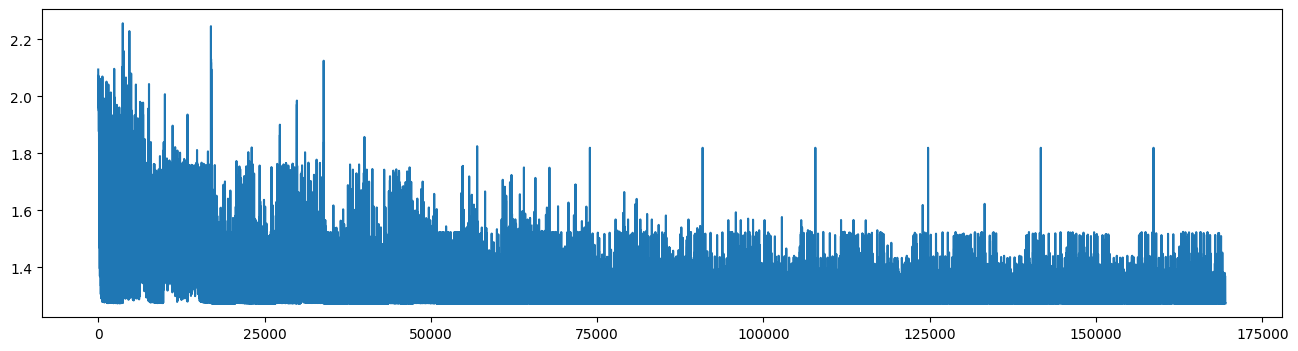

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
plt.plot(model.loss_history)

In [30]:
# get train test metrics
predict_label = []
with torch.no_grad():
    for batch_X, batch_Y in tqdm(zip(sentences_train, sentences_labels_train)):
        predict = model.forward(batch_X.to(device))
        predict_label.append(torch.argmax(predict, dim=1).cpu())

predict_label = torch.cat(predict_label) 
real_label = torch.cat(sentences_labels_train)

print(f'Train BA: {balanced_accuracy_score(real_label, predict_label):.3f}')

0it [00:00, ?it/s]

Train BA: 0.988


In [31]:
predict_label = []
with torch.no_grad():
    for batch_X, batch_Y in tqdm(zip(sentences_test, sentences_labels_test)):
        predict = model.forward(batch_X.to(device))
        predict_label.append(torch.argmax(predict, dim=1).cpu())

predict_label = torch.cat(predict_label) 
real_label = torch.cat(sentences_labels_test)

print(f'Test BA: {balanced_accuracy_score(real_label, predict_label):.3f}')

0it [00:00, ?it/s]

Test BA: 0.666


In [ ]:
# split all df on sentences
sentences_info = []
cur_sentences_info = []

sentences = []
cur_sentence = []
sentences_labels = []
cur_sentences_labels = []

for doc_i, doc in enumerate(tqdm(data)):
    sentence_document = data[doc_i]['document']
    for token_i, token, label in zip(range(len(data[doc_i]['tokens'])), data[doc_i]['tokens'], data[doc_i]['labels']):
        cur_sentence.append(token2num[token])
        cur_sentences_labels.append(label2num[label])
        cur_sentences_info.append([sentence_document, token_i])

        if (token == '.') | (token.endswith('\n')) | (token == '?') | (token == '!'):   
            # if sum(cur_sentences_labels) > 0:
            sentences_info.append(torch.LongTensor(cur_sentences_info))
            sentences.append(torch.LongTensor(cur_sentence))
            sentences_labels.append(torch.LongTensor(cur_sentences_labels))

            cur_sentences_info = []
            cur_sentences_labels = []
            cur_sentence = []
    
    if sum(cur_sentences_labels) > 0:
        sentences_info.append(torch.LongTensor(cur_sentences_info))
        sentences.append(torch.LongTensor(cur_sentence))
        sentences_labels.append(torch.LongTensor(cur_sentences_labels))

    cur_sentences_info = []
    cur_sentences_labels = []
    cur_sentence = []


# get bi-lstm-predict and create result table
results = []

for i in tqdm(range(len(sentences))):
    predict = torch.argmax(model.forward(sentences[i].to(device)).cpu(), dim=1)

    for j in range(1, len(predict)):
        if (predict[j-1] == 1) & (predict[j] == 1):
            predict[j] = 2
        # elif ((predict[j-1] == 2) | (predict[j-1] == 4)) & (predict[j] == 2):
        #     predict[j] = 4
    
    if (predict > 0).sum() > 0:
        results.append(torch.cat((
            sentences_info[i][predict > 0],
            sentences[i][predict > 0].reshape(-1,1),
            predict[predict > 0].reshape(-1,1)
        ), dim=1))


  0%|          | 0/6807 [00:00<?, ?it/s]

  0%|          | 0/282905 [00:00<?, ?it/s]

In [ ]:
results = torch.cat(results)
results = pd.DataFrame(results, columns=['document', 'token_i', 'token', 'label'])

results.loc[results.label == 1, 'label'] = 'B-NAME_STUDENT'
results.loc[results.label == 2, 'label'] = 'I-NAME_STUDENT'

# results.loc[results.label == 2, 'label'] = 'B-USERNAME'
# results.loc[results.label == 4, 'label'] = 'I-USERNAME'

C:\Users\zmitrovich.nik\AppData\Local\Temp\ipykernel_6944\1938258894.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'B-NAME_STUDENT' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  results.loc[results.label == 1, 'label'] = 'B-NAME_STUDENT'


In [ ]:
results = results[results['token'].apply(lambda x: (sum([let.isupper() for let in x]) == 1) & x[0].isupper())].reset_index(drop=True)

TypeError: 'int' object is not iterable